# Training functions 

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import os
import time
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt


class aux_bot():

    def __init__(self,data_path = None, train_forward = False, train_inverse = False, normalize=True):
        # Setup device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Connected: ", self.device)
        self.data_path = data_path
        self.model_path = None
        self.normalize = normalize
        
        # Constant for forward model
        BATCH_SIZE = 16
        EPOCHS = 50
        LEARNING_RATE = 0.0001
        MOMENTUM = 2
        WEIGHT_DECAY = 0 #0.0005
        
        self.upload_data(data_path,batch_size = BATCH_SIZE)

        # Train forward model
        if  train_forward:
            self.fk_net = self.forward_net(hidden=1024)
            self.train_forward(self.fk_net,EPOCHS,LEARNING_RATE,MOMENTUM,WEIGHT_DECAY,annealing=True)
            self.eval_model_forward(self.fk_net,self.fk_train_loss,invert_zy = True)

        # Load forward model instead
        if not train_forward:
            self.fk_net = self.forward_net(hidden=1024)
            self.fk_net.load_state_dict(torch.load('./models/forward_2023_06_16-11_17_17_4.955mm'))
            self.fk_net.eval()
            print("[aux_net] Forward model succesfully loaded")

        # Constant for inverse model
        EPOCHS = 50
        LEARNING_RATE = 0.002
        MOMENTUM = 2
        WEIGHT_DECAY = 0 #0.0005

        # Train inverse model
        if  train_inverse:
            self.ik_net = self.inverse_net(hidden=1024)
            self.train_inverse(self.ik_net,EPOCHS,LEARNING_RATE,MOMENTUM,WEIGHT_DECAY,annealing=True)
            self.eval_model_inverse(self.ik_net,self.ik_train_loss,invert_zy = True)
            
        # Load forward model instead
        if not train_inverse:
            self.inverse_model = self.inverse_net(hidden=1024)
            self.inverse_model.load_state_dict(torch.load('./models/inverse_2023_06_16-11_20_20_6.129pwm'))
            self.inverse_model.eval()
            print("[aux_net] Inverse model succesfully loaded")

    # Apply data normalization
    def normalize_data(self,data,d_type="full"):
        if d_type == "full":
            data = (data-self.min_scale)/(self.max_scale-self.min_scale)
        elif d_type == "motor":
                data = (data-self.min_scale[0:12])/(self.max_scale[0:12]-self.min_scale[0:12])
        elif d_type == "end_part":
            data = (data-self.min_scale[26:29])/(self.max_scale[26:29]-self.min_scale[26:29])
        elif d_type == "end_full":
            data = (data-self.min_scale[26:33])/(self.max_scale[26:33]-self.min_scale[26:33])
        return data
    
    # Return data to original units
    def denormalize_data(self,data,d_type="full"):
        if d_type == "full":
            data = data*(self.max_scale-self.min_scale)+self.min_scale
        elif d_type == "motor":
                data = data*(self.max_scale[0:12]-self.min_scale[0:12])+self.min_scale[0:12]
        elif d_type == "end_part":
            data = data*(self.max_scale[26:29]-self.min_scale[26:29])+self.min_scale[26:29]
        elif d_type == "end_full":
            data = data*(self.max_scale[26:33]-self.min_scale[26:33])+self.min_scale[26:33]
        return data

    # Uploads training dat
    def upload_data(self,data_path,trim_max = None, trim_length = None,batch_size=1):
        '''
        Inputs in data are motor positions [m0,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11]
        Out positions [x_top (0), y_top (1), z_top (2), qx_top (3), qy_top (4), qz_top (5), qw_top (6)
                    x_mid (7), y_mid (8), z_mid (9), qx_mid (10), qy_mid (11), qz_mid (12), qw_mid (13)
                    x_end (14), y_end (15), z_end (16), qx_end (17), qy_end (18), qz_end (19), qw_end (20)]
        '''
        #data = data[:,2:] # Skip first two columns

        self.data = np.loadtxt(data_path, skiprows = 1, delimiter=',',dtype = 'float32')
        self.min_scale = np.amin(self.data,0)
        self.max_scale = np.amax(self.data,0)

        self.raw_data = np.copy(self.data)
        if self.normalize: self.data = self.normalize_data(self.data)
        self.norm_data = np.copy(self.data)
        if trim_max != None: self.data = self.data[self.data[:,27] < trim_max]
        if trim_length != None: self.data = self.data[0:trim_length,:]
            
        # Split into randomized 80/20 train test
        np.random.seed(8) 
        np.random.shuffle(self.data)
        n = np.size(self.data,0)
        self.train_set = self.data[0:int(n*.8),:]
        self.test_set = self.data[int(n*.8):n,:]
        self.train_set_raw = self.raw_data[0:int(n*.8),:]
        self.test_set_raw = self.raw_data[int(n*.8):n,:]

        # Set up data loader
        self.train_loader = torch.utils.data.DataLoader(self.train_set, batch_size = batch_size)
        self.test_loader = torch.utils.data.DataLoader(self.test_set, batch_size = batch_size)
        self.data = {'train': self.train_loader, 'test': self.test_loader, 'train_set' : self.train_set, 'test_set' : self.test_set}

    ########################
    # FORWARD NETWORK
    ########################
    class forward_net(nn.Module):
        def __init__(self, inputs=12, hidden=1024, outputs=7):
            super().__init__()
            self.fc1 = nn.Linear(inputs,hidden)
            self.fc2 = nn.Linear(hidden,hidden)
            self.fc3 = nn.Linear(hidden,outputs)
            self.input_size = inputs
            self.output_size = outputs

        def forward(self,x):
            x = torch.flatten(x, 1)
            x = self.fc1(x)
            x = F.relu(x)
            x = self.fc2(x)
            x = F.relu(x)
            x = self.fc3(x)
            return x
    
    # Training function
    def train_forward(self,fk_net,epochs=10, lr=0.01, momentum=0.9, decay=0.0, verbose=1,annealing=True):
        fk_net.to(self.device)
        losses = []
        criterion = nn.MSELoss()
        self.optimizer = optim.Adam(fk_net.parameters(), lr, weight_decay=decay)
        if annealing:
            scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)
        for epoch in range(epochs):
            sum_loss = 0
            loss_list = []
            for i, batch in enumerate(self.train_loader,0):
                # Split the data into motor inputs and measure pose outputs
                x, y_measured = batch[:,0:12].to(self.device), batch[:,26:33].to(self.device)

                # Reset gradients
                self.optimizer.zero_grad()

                # Run network forward, backward, and then update
                y_pred = fk_net(x)
                loss = criterion(y_pred,y_measured)
                loss.backward()
                self.optimizer.step()

                # Track performance
                loss_list.append(loss.item())
                sum_loss += loss.item()
                if i % 100 == 99:
                    if verbose:
                        print('(Epoch {}, Iter {}) loss: {:.6f}'.format(epoch + 1, i + 1, sum_loss / 100))
                    sum_loss = 0
            if annealing:
                scheduler.step()
            losses.append(np.mean(loss_list))
            loss_list = []
        self.fk_train_loss = losses


    # Find accuracy of final end effector positions (X,Y,Z)
    def test_forward(self,fk_net,data='train'):
        accuracy = []
        err = np.array([])
        # Create data loader
        if data == 'train': loader = self.train_loader
        if data == 'test': loader = self.test_loader
        # Run through the data
        for batch in loader:
            x, y_measured = batch[:,0:12].to(self.device), batch[:,26:33].to(self.device)
            y_pred = fk_net(x)
            max_scale = self.max_scale
            min_scale = self.min_scale
            
            # Convert back to CPU side
            y_pred = y_pred.numpy(force=True)    
            y_measured = y_measured.numpy(force=True)

            if self.normalize:
                y_pred = self.denormalize_data(y_pred,"end_full")
                y_measured = self.denormalize_data(y_measured,"end_full")

            # Calculate error (just positional at this point)
            e = y_pred[:,0:3]-y_measured[:,0:3]
            
            # error = np.sqrt(np.mean(e**2,axis=1)).flatten()
            error = np.linalg.norm(e,axis = 1).flatten()
            accuracy.append(np.mean(error))
            err = np.append(err,error)
        return np.mean(accuracy), err

    # Plots the test accuracy of the model
    def eval_model_forward(self,fk_net,loss,invert_zy = False,auto_encoder=False):
        # Plot losses during training
        plt.close('all')
        f = plt.figure()
        f.set_size_inches(16,4)
        ax1 = f.add_subplot(1,3,1)
        ax2 = f.add_subplot(1,3,2)
        ax3 = f.add_subplot(1,3,3,projection='3d')

        # Plot training loss
        ax1.plot(np.log10(loss),linewidth = 2)
        ax1.set_xlabel("Epochs",fontsize = 14)
        ax1.set_ylabel("Loss",fontsize = 14)
        ax1.set_title("Train Loss (Forward)",fontsize = 16)
        ax1.grid()

        # Determine train and test accuracy
        test_accuracy,test_error = self.test_forward(fk_net,data='test')
        train_accuracy, train_error = self.test_forward(fk_net,data='train')

        # Convert all units
        test_accuracy *= 1000
        test_error = test_error*1000
        train_accuracy *= 1000
        train_error = train_error*1000

        print("Train accuracy {:.10f} mm Test accuracy: {:.10f} mm".format(train_accuracy,test_accuracy))

        # Show testing accuracy
        ax2.hist(test_error,20)
        ax2.set_xlabel("Error (mm)",fontsize = 14)
        ax2.set_ylabel("Count",fontsize = 14)
        ax2.set_title("Positional Error for Test Data",fontsize = 16)
        ax2.grid()

        # Show where errors occur in the workspace
        x = 1000*self.test_set_raw[:,14+12]
        y = 1000*self.test_set_raw[:,15+12]
        z = 1000*self.test_set_raw[:,16+12]

        if invert_zy:
            y_n, z_n = z, y
            y, z = y_n, z_n
            
        # Create scatter plot of distance errors
        p = ax3.scatter(x, y, z, c=test_error, cmap=plt.cm.jet,vmin=0,vmax=0.65*np.max(test_error))
        ax3.view_init(45, 45)
        cb = f.colorbar(p)
        cb.set_label("Error (mm)")
        ax3.set_xlabel("xe",fontsize = 14)
        ax3.set_ylabel("ye",fontsize = 14)
        ax3.set_zlabel("ze",fontsize = 14)
        ax3.set_zlim3d(min(z)-5,max(z)+5)
        ax3.set_title("Aux-Net Forward Model Performance",fontsize = 16)
        ax3.grid()
        plt.tight_layout()
        plt.show()

        # Save model
        if not auto_encoder:
            torch.save(fk_net.state_dict(),
                    './models/forward_'+time.strftime('%Y_%m_%d-%H_%M_%S_') + '{:.3f}mm'.format(test_accuracy))

        return test_accuracy


    # ########################
    # # INVERSE NETWORK
    # ######################## 
    class inverse_net(nn.Module):
        def __init__(self, inputs=7, hidden=1024, outputs=12):
            super().__init__()
            self.fc1 = nn.Linear(inputs,hidden)
            self.fc2 = nn.Linear(hidden,hidden)
            self.fc3 = nn.Linear(hidden,outputs)
            self.input_size = inputs
            self.output_size = outputs

        def forward(self,y):
            y = torch.flatten(y, 1)
            y = self.fc1(y)
            y = F.relu(y)
            y = self.fc2(y)
            y = F.relu(y)
            y = self.fc3(y)
            return y 
    
    # Training function
    def train_inverse(self,ik_net,epochs=10, lr=0.01, momentum=0.9, decay=0.0, verbose=1,annealing=True):
        ik_net.to(self.device)
        losses = []
        criterion = nn.MSELoss()
        self.optimizer = optim.Adam(ik_net.parameters(), lr, weight_decay=decay)
        if annealing:
            scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)
        for epoch in range(epochs):
            sum_loss = 0
            loss_list = []
            for i, batch in enumerate(self.train_loader,0):
                # Split the data into motor inputs and measure pose outputs
                x_measured, y = batch[:,0:12].to(self.device), batch[:,26:33].to(self.device)

                # Reset gradients
                self.optimizer.zero_grad()

                # Run network forward, backward, and then update
                x_pred = ik_net(y)
                loss = criterion(x_pred,x_measured)
                loss.backward()
                self.optimizer.step()

                # Track performance
                loss_list.append(loss.item())
                sum_loss += loss.item()
                if i % 100 == 99:
                    if verbose:
                        print('(Epoch {}, Iter {}) loss: {:.6f}'.format(epoch + 1, i + 1, sum_loss / 100))
                    sum_loss = 0
            if annealing:
                scheduler.step()
            losses.append(np.mean(loss_list))
            loss_list = []
        self.ik_train_loss = losses

    # Find accuracy of final end effector positions (X,Y,Z)
    def test_inverse(self,ik_net,data='train'):
        accuracy = []
        err = np.array([])
        # Create data loader
        if data == 'train': loader = self.train_loader
        if data == 'test': loader = self.test_loader
        # Run through the data
        for batch in loader:
            x_measured, y = batch[:,0:12].to(self.device), batch[:,26:33].to(self.device)
            x_pred = ik_net(y)
            max_scale = self.max_scale
            min_scale = self.min_scale
            # Convert back to CPU side
            x_pred = x_pred.numpy(force=True)    
            x_measured = x_measured.numpy(force=True)

            if self.normalize:
                x_pred = self.denormalize_data(x_pred,"motor")
                x_measured = self.denormalize_data(x_measured,"motor")
        
            # Calculate error
            e = x_pred-x_measured
            
            # error = np.sqrt(np.mean(e**2,axis=1)).flatten()
            error = np.linalg.norm(e,axis = 1).flatten()
            accuracy.append(np.mean(error))
            err = np.append(err,error)
        return np.mean(accuracy), err

    # Plots the test accuracy of the model
    def eval_model_inverse(self,ik_net,loss,invert_zy = False,auto_encoder=False):
        # Plot losses during training
        f = plt.figure()
        f.set_size_inches(20,5)
        ax1 = f.add_subplot(1,3,1)
        ax2 = f.add_subplot(1,3,2)
        ax3 = f.add_subplot(1,3,3,projection='3d')

        # Plot training loss
        ax1.plot(np.log10(loss),linewidth = 2)
        ax1.set_xlabel("Epochs",fontsize = 14)
        ax1.set_ylabel("Loss",fontsize = 14)
        ax1.set_title("Train Loss (Inverse)",fontsize = 16)
        ax1.grid()

        # Determine train and test accuracy
        test_accuracy,test_error = self.test_inverse(ik_net,data='test')
        train_accuracy, train_error = self.test_inverse(ik_net,data='train')

        print("Train accuracy {:.10f} pwm Test accuracy: {:.10f} pwm".format(train_accuracy,test_accuracy))

        # Show testing accuracy
        ax2.hist(test_error,20)
        ax2.set_xlabel("Error (pwm)",fontsize = 14)
        ax2.set_ylabel("Count",fontsize = 14)
        ax2.set_title("PWM Error for Test Data",fontsize = 16)
        ax2.grid()

        # Show where errors occur in the workspace
        x = 1000*self.test_set_raw[:,14+12]
        y = 1000*self.test_set_raw[:,15+12]
        z = 1000*self.test_set_raw[:,16+12]

        if invert_zy:
            y_n, z_n = z, y
            y, z = y_n, z_n
            
        # Create scatter plot of distance errors
        p = ax3.scatter(x, y, z, c=test_error, cmap=plt.cm.jet,vmin=0,vmax=0.65*np.max(test_error))
        ax3.view_init(45, 45)
        cb = f.colorbar(p)
        cb.set_label("Error (pwm)")
        ax3.set_xlabel("xe",fontsize = 14)
        ax3.set_ylabel("ye",fontsize = 14)
        ax3.set_zlabel("ze",fontsize = 14)
        ax3.set_zlim3d(min(z)-5,max(z)+5)
        ax3.set_title("Aux-Net Inverse Model Performance",fontsize = 16)
        ax3.grid()
        plt.tight_layout()
        plt.show()

        # Save model
        if not auto_encoder:
            torch.save(ik_net.state_dict(),
                    './models/inverse_'+time.strftime('%Y_%m_%d-%H_%M_%S_') + '{:.3f}pwm'.format(test_accuracy))

        return test_accuracy

    def inverse_prediction(self):
        with torch.no_grad():
            # Find end effector position we want to predict
            y = torch.from_numpy(self.norm_data[0:1000,26:33])

            x = self.inverse_model(y)

            x_real = self.denormalize_data(x,"motor")
            x_real = x_real.numpy(force=True)
            
            np.savetxt("./predicted_motor_inputs.csv",x_real,delimiter=",",header="m0,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11")



### Autoencoder Network ###

In [2]:
# Autoencoder network for model refinement
class auto_bot(aux_bot):
    def __init__(self,data_path=None,normalize=True):

        # Setup device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Connected: ", self.device)
        self.normalize = True

        # Training constants
        BATCH_SIZE = 16
        EPOCHS = 30
        LEARNING_RATE = 0.0001
        MOMENTUM = 2
        WEIGHT_DECAY = 0
        
        self.upload_data(data_path=data_path,batch_size = BATCH_SIZE)

        self.ae_net = self.auto_net() 
        self.train_auto(EPOCHS,LEARNING_RATE,MOMENTUM,WEIGHT_DECAY,annealing=True)
        self.eval_model_inverse(self.ae_net.decoder,np.zeros(1),auto_encoder=True,invert_zy=True)
        self.eval_model_forward(self.ae_net.encoder,np.zeros(1),auto_encoder=True,invert_zy=True)

    class auto_net(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.encoder = aux_bot.forward_net()
            self.encoder.load_state_dict(torch.load('./models/forward_2023_06_16-11_17_17_4.955mm'))
            self.encoder.eval()
            print("[auto_net] Forward model succesfully loaded")

            self.decoder = aux_bot.inverse_net()
            self.decoder.load_state_dict(torch.load('./models/inverse_2023_06_16-11_20_20_6.129pwm'))
            self.decoder.eval()
            print("[auto_net] Forward model succesfully loaded")

        def forward(self,x):
            x=torch.flatten(x, 1)
            with torch.no_grad():    
                encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    # Training function
    def train_auto(self,epochs=10, lr=0.01, momentum=0.9, decay=0.0, verbose=1,annealing=True):
        self.ae_net.to(self.device)
        losses = []
        criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.ae_net.parameters(), lr, weight_decay=decay)
        if annealing:
            scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)
        for epoch in range(epochs):
            sum_loss = 0
            loss_list = []
            for i, batch in enumerate(self.train_loader,0):
                # Split the data into motor inputs and measure pose outputs
                x = batch[:,0:12].to(self.device)
                # Reset gradients
                self.optimizer.zero_grad()

                # Run network forward, backward, and then update
                x_predict = self.ae_net(x)
                loss = criterion(x_predict,x)
                loss.backward()
                self.optimizer.step()

                # Track performance
                loss_list.append(loss.item())
                sum_loss += loss.item()
                if i % 100 == 99:
                    if verbose:
                        print('(Epoch {}, Iter {}) loss: {:.6f}'.format(epoch + 1, i + 1, sum_loss / 100))
                    sum_loss = 0
            if annealing:
                scheduler.step()
            losses.append(np.mean(loss_list))
            loss_list = []
        self.auto_train_loss = losses

# Launch aux-bot

Connected:  cuda:0


C:\Users\Kuba\AppData\Local\Temp\ipykernel_31636\978533461.py:72: RuntimeWarning: invalid value encountered in divide
  data = (data-self.min_scale)/(self.max_scale-self.min_scale)


(Epoch 1, Iter 100) loss: 0.024974
(Epoch 1, Iter 200) loss: 0.005274
(Epoch 1, Iter 300) loss: 0.003676
(Epoch 1, Iter 400) loss: 0.002817
(Epoch 1, Iter 500) loss: 0.002169
(Epoch 1, Iter 600) loss: 0.001818
(Epoch 1, Iter 700) loss: 0.001694
(Epoch 1, Iter 800) loss: 0.001444
(Epoch 1, Iter 900) loss: 0.001446
(Epoch 1, Iter 1000) loss: 0.001423
(Epoch 1, Iter 1100) loss: 0.001313
(Epoch 1, Iter 1200) loss: 0.001281
(Epoch 1, Iter 1300) loss: 0.001233
(Epoch 1, Iter 1400) loss: 0.001256
(Epoch 1, Iter 1500) loss: 0.001286
(Epoch 2, Iter 100) loss: 0.001208
(Epoch 2, Iter 200) loss: 0.001196
(Epoch 2, Iter 300) loss: 0.001186
(Epoch 2, Iter 400) loss: 0.001168
(Epoch 2, Iter 500) loss: 0.001110
(Epoch 2, Iter 600) loss: 0.001088
(Epoch 2, Iter 700) loss: 0.001104
(Epoch 2, Iter 800) loss: 0.001052
(Epoch 2, Iter 900) loss: 0.001077
(Epoch 2, Iter 1000) loss: 0.001117
(Epoch 2, Iter 1100) loss: 0.001043
(Epoch 2, Iter 1200) loss: 0.001046
(Epoch 2, Iter 1300) loss: 0.001020
(Epoch 2, 

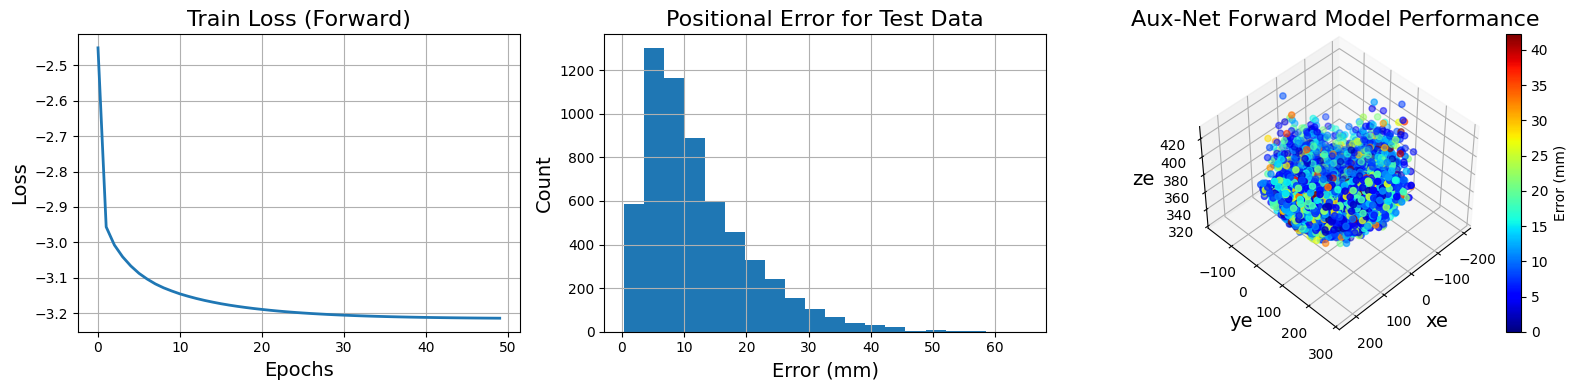

[aux_net] Inverse model succesfully loaded


In [5]:
bot = aux_bot(data_path = '../Data/Data Collections/30000_pose_raw_data_07_05_2023.csv',train_forward=True,train_inverse=False,normalize=True)

#auto = auto_bot(data_path = '../Data/Data Collections/32000 Guassian Rep with Variance-09-Jun-2023.csv')
#bot.inverse_prediction()